In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

- Goodreads dataset contains infromation book titles, average rating, number of pages, ratings count, text reviews count, so collaborative filtering is not possible. 
- we will use content based filtering. We will use book title, author, and publisher to recommend books to users. (simple recommendation)
- For feature based recommendation We will use cosine similarity to find similar books. (based on pairwise feature distance)

### Clean dataset

In [5]:
goodreads = pd.read_csv(r'./goodreads/books.csv', skiprows = [3349, 4703, 5878, 8980])

# remove uneven spacing in column names
goodreads.rename(columns={'  num_pages': 'num_pages'}, inplace=True)
# convert publication date to datetime format
goodreads['publication_date'] = pd.to_datetime(goodreads['publication_date'], errors='coerce')
# remove duplicate rows
goodreads.drop_duplicates(inplace=True)

# set average rating to float, remove rows with no average rating, num_pages to int, ratings_count to int, text_reviews_count to int
goodreads['average_rating'] = goodreads['average_rating'].astype(float)
goodreads = goodreads[goodreads['average_rating'] != 0]
goodreads['num_pages'] = goodreads['num_pages'].astype(int)
goodreads['ratings_count'] = goodreads['ratings_count'].astype(int)
goodreads['text_reviews_count'] = goodreads['text_reviews_count'].astype(int)

# number of years since publication
goodreads['years_since_publication'] = 2023 - goodreads['publication_date'].dt.year
# drop publication date
goodreads.drop(columns=['publication_date'], inplace=True)

#  remove nan values
goodreads.dropna(inplace=True)
goodreads.reset_index(drop=True, inplace=True)

# replacing  'J.K. Rowling/Mary GrandPré' with 'J.K. Rowling'
goodreads['authors'] = goodreads['authors'].str.replace('J.K. Rowling/Mary GrandPré', 'J.K. Rowling')

# take only the first author
goodreads['authors'] = goodreads['authors'].str.split('/').str[0]

print(goodreads.info())
display(goodreads)

# save to csv
goodreads.to_csv(r'./goodreads/books_clean.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11096 entries, 0 to 11095
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bookID                   11096 non-null  int64  
 1   title                    11096 non-null  object 
 2   authors                  11096 non-null  object 
 3   average_rating           11096 non-null  float64
 4   isbn                     11096 non-null  object 
 5   isbn13                   11096 non-null  int64  
 6   language_code            11096 non-null  object 
 7   num_pages                11096 non-null  int32  
 8   ratings_count            11096 non-null  int32  
 9   text_reviews_count       11096 non-null  int32  
 10  publisher                11096 non-null  object 
 11  years_since_publication  11096 non-null  float64
dtypes: float64(2), int32(3), int64(2), object(5)
memory usage: 910.3+ KB
None


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publisher,years_since_publication
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,0439785960,9780439785969,eng,652,2095690,27591,Scholastic Inc.,17.0
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,2153167,29221,Scholastic Inc.,19.0
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,Scholastic,20.0
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.56,043965548X,9780439655484,eng,435,2339585,36325,Scholastic Inc.,19.0
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling,4.78,0439682584,9780439682589,eng,2690,41428,164,Scholastic,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11091,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann,4.06,1560254416,9781560254416,eng,512,156,20,Da Capo Press,19.0
11092,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,Penguin Books,35.0
11093,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,Penguin Books,30.0
11094,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,Ecco,16.0


### EDA plotting

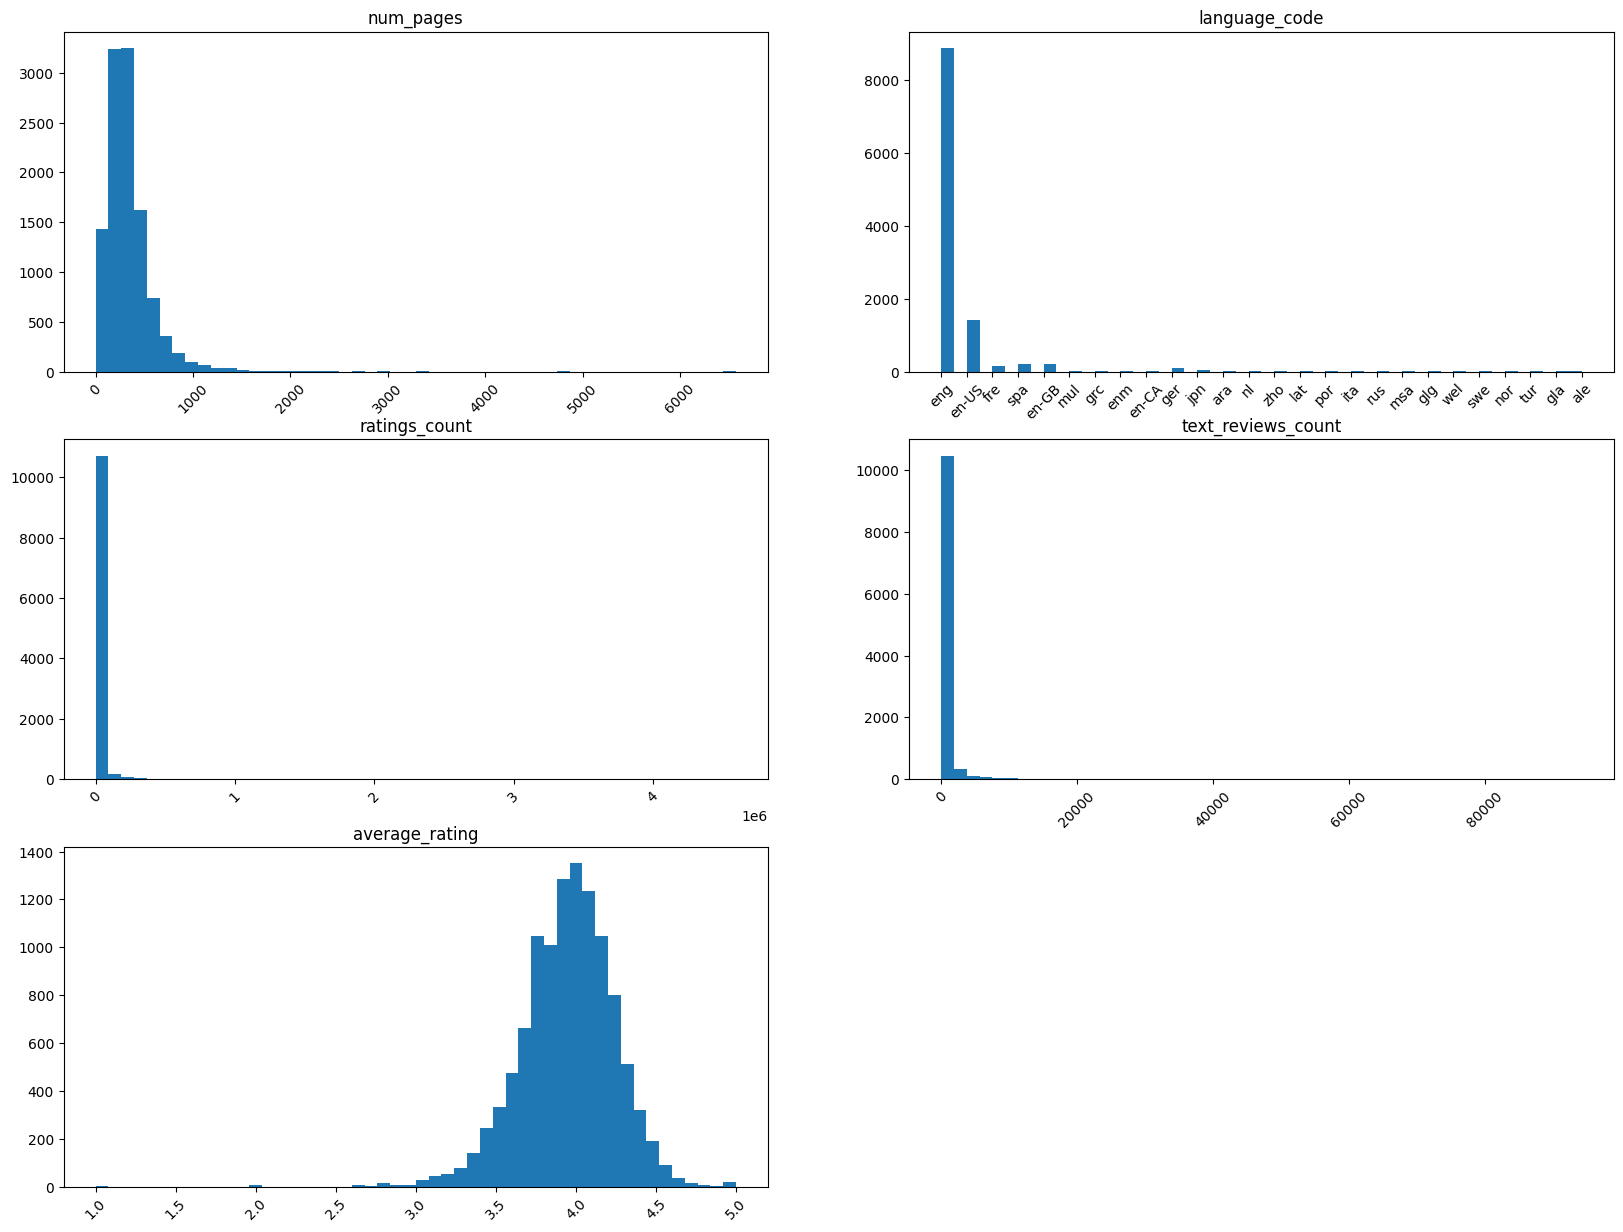

In [6]:
# plot histograms for num_pages, language_code, ratings_count, text_reviews_count, average_rating
fig = plt.figure(figsize=(20,15))
for i, col in enumerate(['num_pages', 'language_code', 'ratings_count', 'text_reviews_count', 'average_rating']):
    ax = fig.add_subplot(3, 2, i+1)
    ax.hist(goodreads[col], bins=50)
    # tilt the x-axis labels
    plt.xticks(rotation=45)
    ax.set_title(col)
plt.show()

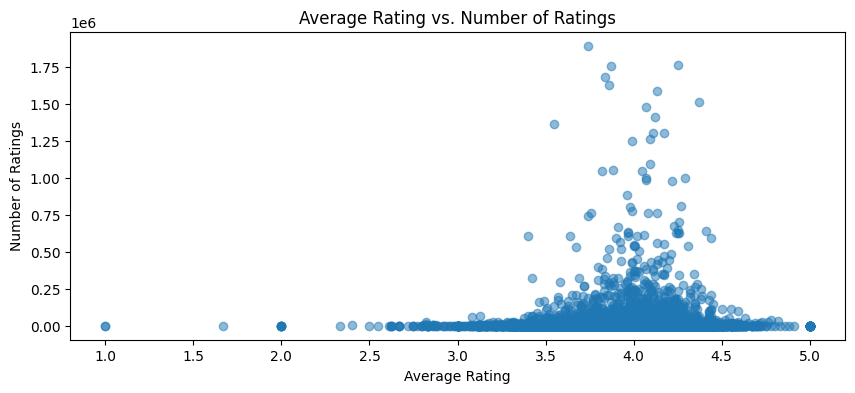

In [7]:
# scatter plot between average rating and number of ratings
plt.figure(figsize=(10,4))
sc_df = goodreads[~(goodreads.ratings_count > 2000000)]
plt.scatter(sc_df['average_rating'], sc_df['ratings_count'], alpha=0.5)
plt.xlabel('Average Rating')
plt.ylabel('Number of Ratings')
plt.title('Average Rating vs. Number of Ratings')
plt.show()

In [8]:
# plot histograms for num_pages, language_code, ratings_count, text_reviews_count, average_rating using plotly
from plotly.subplots import make_subplots
fig = make_subplots(rows=3, cols=2, subplot_titles=("Number of Pages", "Language Code", "Ratings Count", "Text Reviews Count", "Average Rating"))
fig.add_trace(go.Histogram(x=goodreads['num_pages'], name='Number of Pages'), row=1, col=1)
fig.add_trace(go.Histogram(x=goodreads['language_code'], name='Language Code'), row=1, col=2)
fig.add_trace(go.Histogram(x=goodreads['ratings_count'], name='Ratings Count'), row=2, col=1)
fig.add_trace(go.Histogram(x=goodreads['text_reviews_count'], name='Text Reviews Count'), row=2, col=2)
fig.add_trace(go.Histogram(x=goodreads['average_rating'], name='Average Rating'), row=3, col=1)
fig.update_layout(height=1200, width=1200,)
                  # title_text="Histograms for Number of Pages, Language Code, Ratings Count, Text Reviews Count, Average Rating")
fig.show()

### Correlation plot between numerical features

Looks like there is absolutely no correlation between any of the numerical features.
This is a good thing, as it means that we can use all of them in our model.

- **number of pages** and **average rating** have very very small correlation, which amounts to nothing.
- **ratings count** and **text reviews count** have a decent amount of correlation
- **average rating**  doesnt have any correlation with any other feature

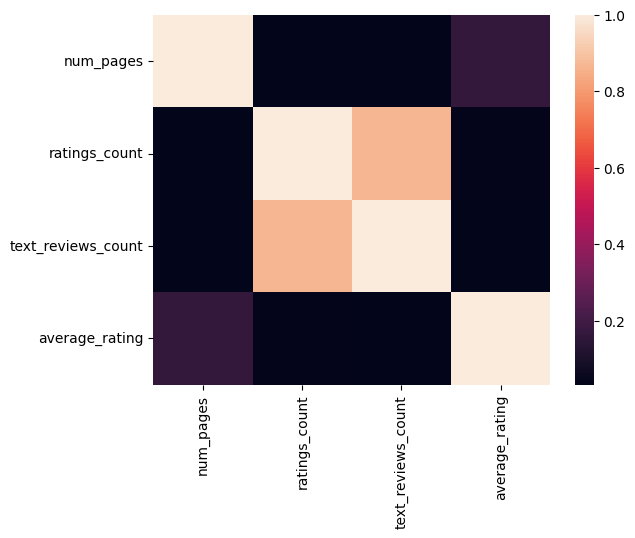

In [9]:
# plot correlation matrix
corr = goodreads[['num_pages', 'ratings_count', 'text_reviews_count', 'average_rating']].corr()
import seaborn as sns
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [10]:
goodreads.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publisher', 'years_since_publication'],
      dtype='object')

### Simple similarity based on author/publisher

In [11]:
"""
Which transforms text to feature vectors that can be used as input to estimator.

Cosine Similarity to calculate a numeric value that denotes the similarity between two books.

goodreads dataframe has ['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'] columns.
"""

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

similarity_criteria = 'authors'
text_freq = TfidfVectorizer(stop_words='english')
text_matrix = text_freq.fit_transform(goodreads[similarity_criteria])

cosine_sim = linear_kernel(text_matrix, text_matrix)
# numeric features = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date']
# categorical features = ['language_code', 'publisher']

In [13]:
# Build a 1-dimensional array with book titles
titles = goodreads['title']
indices = pd.Series(goodreads.index, index=goodreads['title'])

# Function that get book recommendations based on the cosine similarity score of book authors
def recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return goodreads.iloc[book_indices]

recommendations('Poor People').head(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publisher,years_since_publication
11090,45630,Whores for Gloria,William T. Vollmann,3.69,0140231579,9780140231571,en-US,160,932,111,Penguin Books,29.0
11091,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann,4.06,1560254416,9781560254416,eng,512,156,20,Da Capo Press,19.0
11092,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,Penguin Books,35.0
11093,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,Penguin Books,30.0
11094,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,Ecco,16.0


### Feature based setup

In [5]:
"""
goodreads dataframe has ['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'] columns.
"""

# catrgorical data columns: authors, language_code, publisher
# numerical data columns: average_rating, num_pages, ratings_count, text_reviews_count, years_since_publication

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
import pickle

numerical_columns = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'years_since_publication']
categorical_columns = ['authors', 'language_code', 'publisher']

# encoding categorical data
def encode_data(df:pd.DataFrame) -> pd.DataFrame:
       """ 
       This function encodes the categorical data in the dataframe.
       """
       # encoding authors column
       encoder = OrdinalEncoder()
       df[categorical_columns] = encoder.fit_transform(df[categorical_columns])

       # save the encoder
       with open('encoder.pkl', 'wb') as f:
              pickle.dump(encoder, f)
            
       return df

# scaling numerical data
def scale_data(df:pd.DataFrame) -> pd.DataFrame:
       """
       This function scales the numerical data in the dataframe.
       """

       scaler = MinMaxScaler()
       numerical_columns = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'years_since_publication']
       df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

       # save the scaler
       with open('scaler.pkl', 'wb') as f:
              pickle.dump(scaler, f)

       return df

def preprocess_data(df:pd.DataFrame) -> pd.DataFrame:
       df = encode_data(df)
       df = scale_data(df)
       return df

def get_original_data(df):
       """
       This function returns the original data from the scaled and encoded data.
       """
       # load the encoder
       with open('encoder.pkl', 'rb') as f:
              encoder = pickle.load(f)
       # load the scaler
       with open('scaler.pkl', 'rb') as f:
              scaler = pickle.load(f)
       # get the original data
       df[categorical_columns] = encoder.inverse_transform(df[categorical_columns])
       df[numerical_columns] = scaler.inverse_transform(df[numerical_columns])
       return df


In [6]:
pre_process_df = preprocess_data(goodreads.copy(deep=True))
display(goodreads.head())
pre_process_df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publisher,years_since_publication
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,0439785960,9780439785969,eng,652,2095690,27591,Scholastic Inc.,17.0
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,2153167,29221,Scholastic Inc.,19.0
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,Scholastic,20.0
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.56,043965548X,9780439655484,eng,435,2339585,36325,Scholastic Inc.,19.0
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling,4.78,0439682584,9780439682589,eng,2690,41428,164,Scholastic,19.0


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publisher,years_since_publication
0,1,Harry Potter and the Half-Blood Prince (Harry ...,1589.0,0.8925,0439785960,9780439785969,5.0,0.099148,0.455816,0.292696,1762.0,0.116667
1,2,Harry Potter and the Order of the Phoenix (Har...,1589.0,0.8725,0439358078,9780439358071,5.0,0.132299,0.468317,0.309988,1762.0,0.133333
2,4,Harry Potter and the Chamber of Secrets (Harry...,1589.0,0.8550,0439554896,9780439554893,5.0,0.053528,0.001377,0.002588,1757.0,0.141667
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,1589.0,0.8900,043965548X,9780439655484,5.0,0.066150,0.508864,0.385350,1762.0,0.133333
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,1589.0,0.9450,0439682584,9780439682589,5.0,0.409063,0.009011,0.001740,1757.0,0.133333


In [26]:

# calculate similarity between all books
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
features = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'years_since_publication']

def get_similarity_matrix(df:pd.DataFrame) -> pd.DataFrame:
       """
       Calculate similarity between all books in the dataset
       :param df: dataframe containing all books
       """
       # calculate similairity for each book
       #similarity_matrix = np.zeros((df.shape[0], df.shape[0]))
       features = df[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'years_since_publication',]]# 'authors', 'language_code', 'publisher']]
       similarity_matrix = cosine_similarity(features)
       similarity_df = pd.DataFrame(similarity_matrix, index=df['bookID'].values, columns=df['bookID'].values)
       return similarity_df

similarity_df = get_similarity_matrix(pre_process_df)


In [25]:
def get_closest_bookname(book_title:str, df:pd.DataFrame):
       """
       book_title: the book name to query
       df: the dataset to query
       """
       # if the book name is not in the dataset, return the closest book name
       if book_title not in df['title'].values:
              # check if the book_title is a substring of any book name              
              book_title = df[df['title'].apply(lambda x: x.lower()).str.contains(book_title.lower())]['title'].values
              if len(book_title) == 0:
                     return None
              else:
                     return book_title[0]
       else:
              return book_title
       

def get_feature_based_rec(book_title:str, similarity_df:pd.DataFrame, goodreads:pd.DataFrame, n:int=10) -> pd.DataFrame:
       """
       book_title: the book name to query
       similarity_df: the similarity matrix
       goodreads: the goodreads dataset
       n: number of recommendations
       """

       book_title = get_closest_bookname(book_title, goodreads.copy(deep=True))
       print(book_title)

       book_id = goodreads[goodreads['title']==book_title]['bookID'].values[0]
       print(f"Query Book:")
       display(goodreads[goodreads['bookID']==book_id])
       similar_books = similarity_df[book_id].sort_values(ascending=False)[1:n+1]
       similar_books = pd.DataFrame(similar_books).reset_index()
       similar_books.columns = ['bookID', 'similarity_score']
       similar_books = pd.merge(similar_books, goodreads, on='bookID', how='left')
       return similar_books

get_feature_based_rec('Daughter of Fortune', similarity_df, goodreads, 10)


Daughter of Fortune
Query Book:


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publisher,years_since_publication
1499,5207,Daughter of Fortune,Isabel Allende,3.91,006019491X,9780060194918,eng,399,1005,95,Harper,24.0


,bookID,similarity_score,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publisher,years_since_publication
0,18427,0.999999,In the Name of Love and Other True Cases (Crim...,Ann Rule,4.04,067179356X,9780671793562,eng,414,1353,53,Pocket Books,25.0
1,35149,0.999998,Star Wars: The Approaching Storm,Alan Dean Foster,3.51,0345443004,9780345443007,eng,344,3947,100,Del Rey Books,21.0
2,7582,0.999998,Awakening Intuition: Using Your Mind-Body Netw...,Mona Lisa Schulz,3.93,0609804243,9780609804247,eng,397,317,32,Three Rivers Press,24.0
3,12807,0.999998,The Crazed,Ha Jin,3.50,0434010537,9780434010530,eng,336,15,1,Arrow (A Division of Random House Group),21.0
4,13879,0.999997,Shards of a Broken Crown (The Serpentwar Saga ...,Raymond E. Feist,4.02,0380973995,9780380973996,en-US,417,131,4,AvonEos,25.0
5,43089,0.999997,Industry and Empire: The Birth of the Industri...,Eric Hobsbawm,3.92,1565845617,9781565845619,eng,411,301,14,The New Press,24.0
6,43313,0.999995,Trail of Tears: The Rise and Fall of the Chero...,John Ehle,4.15,0385239548,9780385239547,eng,424,3166,152,Anchor Books,26.0
7,38264,0.999994,Moll Flanders,Daniel Defoe,3.52,0375760105,9780375760105,eng,335,387,54,Modern Library,21.0
8,28425,0.999994,Intimate Enemies,Shana Abe,3.81,0553581996,9780553581997,eng,390,401,27,Bantam,23.0
9,18966,0.999994,The Silmarillion,J.R.R. Tolkien,3.92,0261102427,9780261102422,eng,384,292,40,HarperCollins,24.0


### euclidean distance based

In [ ]:

# numerical feature based recommender
features = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'years_since_publication', 'authors', 'language_code', 'publisher']

def get_recommendations(df:pd.DataFrame, book_title:str, top_n:int=10) -> pd.DataFrame:
       # get the index of the book
       book_index = df[df['title'] == book_title].index[0]

       # get the book at the index
       book = df.iloc[book_index]

       # get the euclidean distance between the book and all other books
       distances = df[features].apply(lambda x: np.sqrt(np.sum((x - book[features])**2, axis=0)), axis=1)

       # sort the distances and get the top n books
       distances = distances.sort_values(ascending=True)[1:top_n+1]

       # get the book indices
       book_indices = distances.index

       # return the book details
       return df.iloc[book_indices]

get_recommendations(pre_process_df, 'The Hobbit').head(10)

In [ ]:
result = get_recommendations(pre_process_df, 'The Hobbit').head(5)

In [ ]:
get_original_data(result)

In [ ]:
goodreads[goodreads['title']=='The Hobbit']